In [1]:
import os
import sys
import asyncio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

from qdrant_client import QdrantClient
from langchain.vectorstores import Qdrant

from ragas import SingleTurnSample
from ragas.metrics import (
    Faithfulness, 
    LLMContextPrecisionWithReference,
    ResponseRelevancy,
    LLMContextRecall
)
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper

/Users/azajac/Desktop/RAGSystem/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir('../')

from embedding.embedder import GeminiEmbeddings, VertexAIChat
from retrieval.retriever import retrieve
from retrieval.rerank import rerank
from services.gemini import call_gemini

load_dotenv()


True

In [3]:
embedding_model = GeminiEmbeddings()

vectorstore = Qdrant(
    client=QdrantClient(host="localhost", port=6333),
    collection_name="ifc_report",
    embeddings=embedding_model
)

evaluator_llm = LangchainLLMWrapper(VertexAIChat(model="gemini-2.0-flash", temperature=0.0))
evaluator_embeddings = LangchainEmbeddingsWrapper(embedding_model)


/var/folders/1t/h_rzg3dd45s52xp3hw0nqzvc0000gp/T/ipykernel_88453/2660325501.py:3: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-qdrant package and should be used instead. To use it run `pip install -U :class:`~langchain-qdrant` and import as `from :class:`~langchain_qdrant import Qdrant``.
  vectorstore = Qdrant(


In [4]:
os.chdir('../')

df = pd.read_csv("./data/RAG_evaluation_dataset.csv")
df.head()


,Question,Ground_Truth_Context,Ground_Truth_Answer,Page_Number,Context_Content_Type
0,What is the official title of the financial re...,IFC 2024 ANNUAL REPORT FINANCIALS,"The title of the document is ""IFC 2024 ANNUAL ...",1,text
1,What was IFC's Net Income for the fiscal year ...,"""Net income (loss) (Section VIII)"",""$ 1,485 ""","The Net income for the year ended June 30, 202...",4,table
2,What was the total value of IFC's assets as of...,"""Total assets"", ""$110,547"" (2023 column)","Total assets as of June 30, 2023, were $110,54...",4,table
3,What is the stated mission of the Internationa...,IFC's mission as one of the WBG entities-is to...,IFC's mission is to end extreme poverty and bo...,5,text
4,What was the revised subscription deadline for...,"In April 2024, the subscription deadline for t...",The subscription deadline for the GCI was exte...,5,text


In [5]:
async def async_call_gemini(context: str, question: str) -> str:
    loop = asyncio.get_running_loop()
    response = await loop.run_in_executor(None, call_gemini, context, question)
    return response


In [ ]:
results_with_reranking = []
results_without_reranking = []

async def main(reranking=True):
    results = []
    for i, row in df.iterrows():
        question = row['Question']
        reference = row['Ground_Truth_Context']

        retrieved_docs = retrieve(vectorstore, question)
        if reranking:
            retrieved_docs = rerank(question, retrieved_docs)

            
        retrieved_contexts = [doc.page_content for doc in retrieved_docs]
        
        response_text = await async_call_gemini(retrieved_contexts, question)

        sample = SingleTurnSample(
            user_input=question,
            reference=reference,
            retrieved_contexts=retrieved_contexts,
            response=response_text,
        )

        faithfulness = await Faithfulness(llm=evaluator_llm).single_turn_ascore(sample)
        context_precision = await LLMContextPrecisionWithReference(llm=evaluator_llm).single_turn_ascore(sample)
        response_relevancy = await ResponseRelevancy(llm=evaluator_llm, embeddings=evaluator_embeddings).single_turn_ascore(sample)
        context_recall = await LLMContextRecall(llm=evaluator_llm).single_turn_ascore(sample)

        results.append({
            "question": question,
            "faithfulness": faithfulness,
            "context_precision": context_precision,
            "response_relevancy": response_relevancy,
            "context_recall": context_recall
        })

    return results


In [11]:
results_with_reranking = await main(True)
results_with_reranking_df = pd.DataFrame(results_with_reranking)
results_with_reranking_df.head(35)

,question,faithfulness,context_precision,response_relevancy,context_recall
0,What is the official title of the financial re...,1.0,0.916667,0.650934,0.000000
1,What was IFC's Net Income for the fiscal year ...,1.0,1.000000,0.882756,0.500000
2,What was the total value of IFC's assets as of...,1.0,0.325000,0.000000,0.000000
3,What is the stated mission of the Internationa...,1.0,0.250000,0.768122,1.000000
4,What was the revised subscription deadline for...,1.0,1.000000,0.833696,1.000000
5,What was the Income Available for Designations...,1.0,1.000000,0.899122,1.000000
6,"What were IFC's total disbursements, excluding...",1.0,1.000000,0.853531,0.500000
7,What was the approximate value of IFC's outsta...,1.0,0.000000,0.000000,0.000000
8,With which accounting principles do IFC's cons...,1.0,1.000000,0.850770,1.000000
9,"What was the value attributed to ""PCRF Income""...",1.0,0.833333,0.763846,1.000000


In [13]:
results_without_reranking = await main(False)
results_without_reranking_df = pd.DataFrame(results_without_reranking)
results_without_reranking_df.head(20)

,question,faithfulness,context_precision,response_relevancy,context_recall
0,What is the official title of the financial re...,1.0,0.789847,0.648579,1.0
1,What was IFC's Net Income for the fiscal year ...,1.0,0.808960,0.834898,1.0
2,What was the total value of IFC's assets as of...,1.0,0.571582,0.000000,0.0
3,What is the stated mission of the Internationa...,1.0,0.266667,0.768122,1.0
4,What was the revised subscription deadline for...,1.0,1.000000,0.713377,1.0
5,What was the Income Available for Designations...,1.0,0.727558,0.752985,1.0
6,"What were IFC's total disbursements, excluding...",1.0,0.694878,0.853531,0.5
7,What was the approximate value of IFC's outsta...,1.0,0.502140,0.000000,0.0
8,With which accounting principles do IFC's cons...,1.0,0.793076,0.818750,1.0
9,"What was the value attributed to ""PCRF Income""...",1.0,0.767952,0.858767,1.0


In [12]:
avg_scores = results_with_reranking_df.mean(numeric_only=True).round(3)

print("\n== AVERAGES METRICS ==")
print(avg_scores)


== AVERAGES METRICS ==
faithfulness          0.971
context_precision     0.781
response_relevancy    0.644
context_recall        0.664
dtype: float64


In [14]:
avg_scores = results_without_reranking_df.mean(numeric_only=True).round(3)

print("\n== AVERAGES METRICS ==")
print(avg_scores)


== AVERAGES METRICS ==
faithfulness          0.924
context_precision     0.534
response_relevancy    0.566
context_recall        0.743
dtype: float64


In [20]:
results_with_reranking_df["question_id"] = range(len(results_with_reranking_df))
results_without_reranking_df["question_id"] = range(len(results_without_reranking_df))

results_with_reranking_df["method"] = "With Reranking"
results_without_reranking_df["method"] = "Without Reranking"

df_combined = pd.concat([results_with_reranking_df, results_without_reranking_df], ignore_index=True)

In [24]:
def plot_metric_comparison(df, metric):
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(
        x="question_id", y=metric, hue="method", data=df
    )
    ax.set_title(f"Comparison of {metric.replace('_', ' ').title()} by Question ID", fontsize=14)
    ax.set_ylabel("Metric Value")
    ax.set_xlabel("Question ID")
    plt.legend(title="Method")
    plt.tight_layout()
    plt.show()


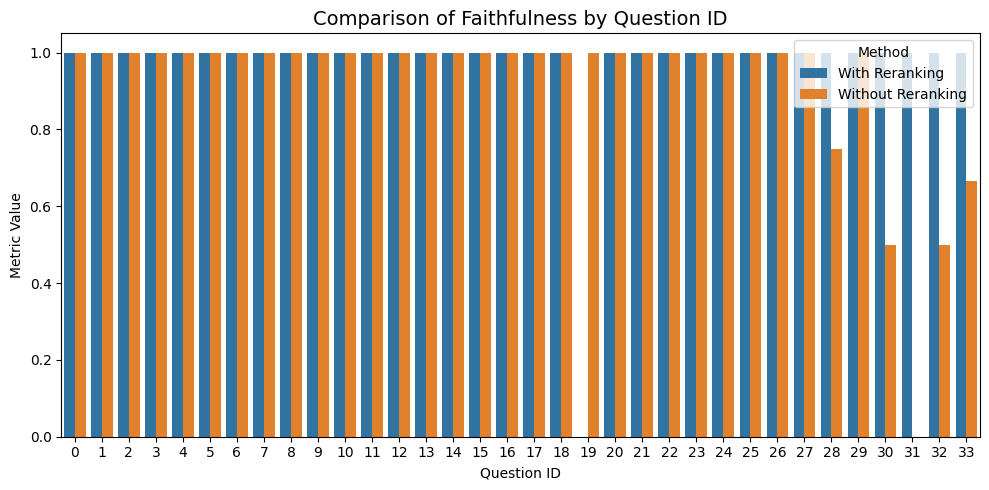

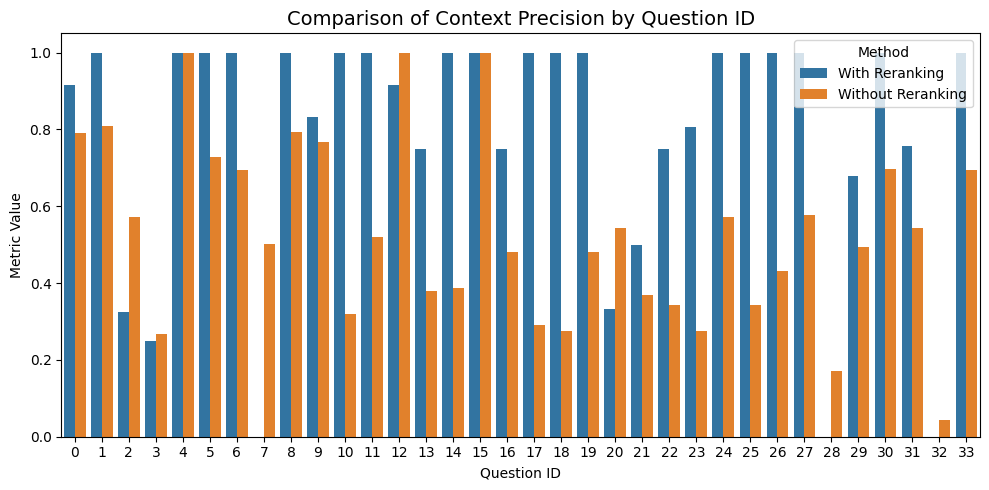

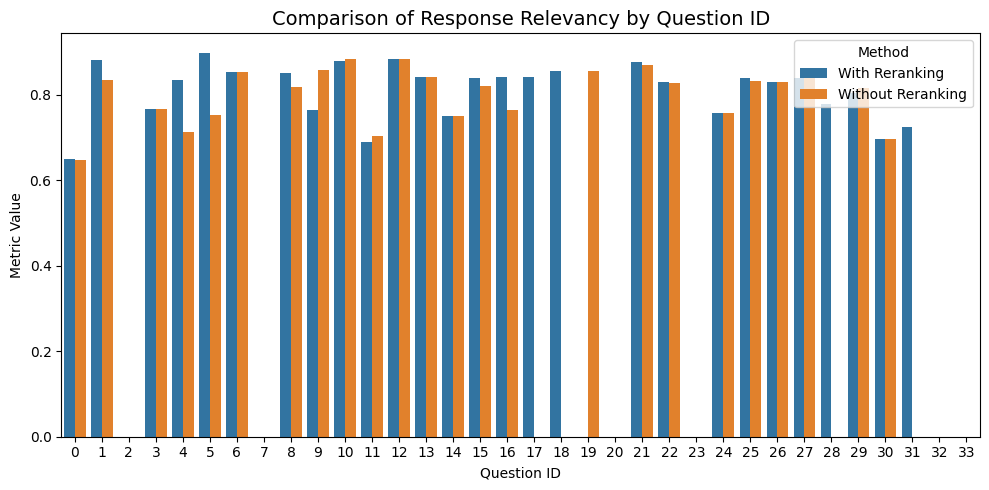

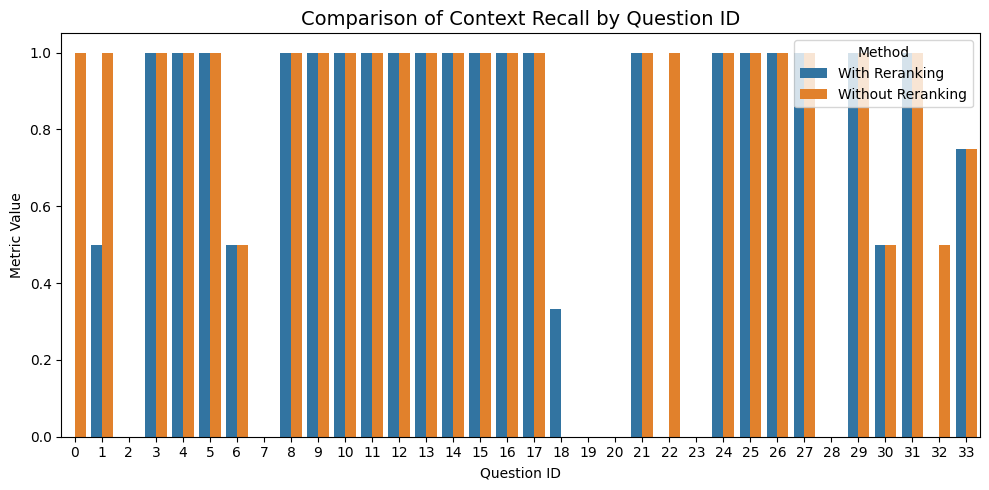

In [25]:
metrics = ["faithfulness", "context_precision", "response_relevancy", "context_recall"]

for metric in metrics:
    plot_metric_comparison(df_combined, metric)